In [10]:
!pip install tensorflow

In [3]:
!pip install -U tensorflow_datasets

  Obtaining dependency information for tensorflow_datasets from https://files.pythonhosted.org/packages/fe/18/4865973f5469cfe33bbe1cfc2f1918335eb44f4cc3d316c1bce22c1af2bc/tensorflow_datasets-4.9.4-py3-none-any.whl.metadata
  Using cached tensorflow_datasets-4.9.4-py3-none-any.whl.metadata (9.2 kB)
  Obtaining dependency information for etils[enp,epath,etree]>=0.9.0 from https://files.pythonhosted.org/packages/37/10/dd5b124f037a636783e416a2fe839edd7ec63c0dce7ce4f3c1da029aeb80/etils-1.7.0-py3-none-any.whl.metadata
  Using cached etils-1.7.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached promise-2.3-py3-none-any.whl
  Obtaining dependency information for tensorflow-metadata from https://files.pythonhosted.org/packages/41/23/3705c7139886c079ef4c0e3be56a5a1fb90e9ee413a4b7caaee0ee0ea6fe/tensorflow_metadata-1.14.0-py3-none-any.whl.metadata
  Using cached tensorflow_metadata-1.14.0-py3-none-any.whl.metadata (2.1 kB)
  Obtaining dependency information for importlib_resources from https://fil

In [23]:
import tensorflow as tf

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']




In [24]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [25]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [26]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()



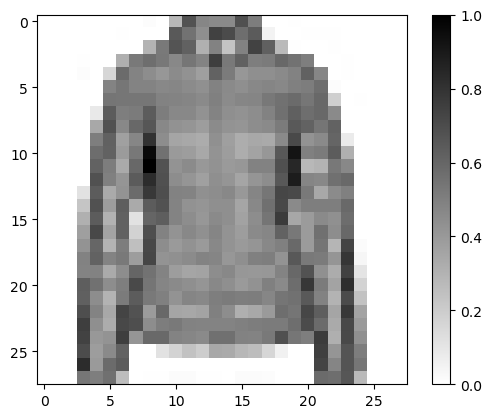

In [27]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

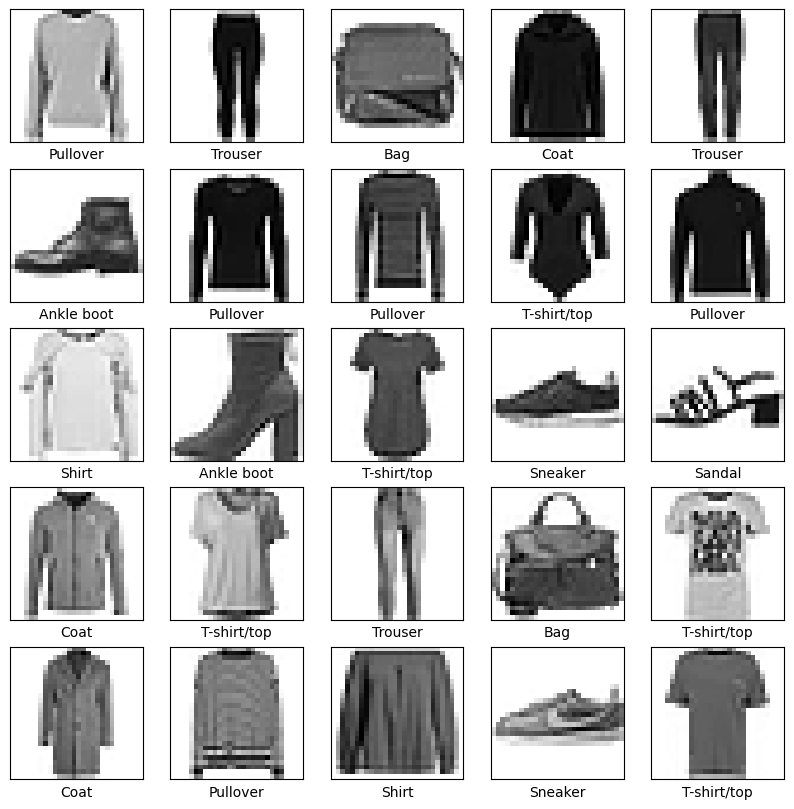

In [28]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [31]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [32]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 22s 5ms/step - loss: 0.4979 - accuracy: 0.8259
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3726 - accuracy: 0.8656
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3398 - accuracy: 0.8751
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3125 - accuracy: 0.8853
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3002 - accuracy: 0.8899


In [33]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 8ms/step - loss: 0.3590 - accuracy: 0.8675
Accuracy on test dataset: 0.8675000071525574


In [34]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 195ms/step


In [35]:
predictions.shape

(32, 10)

In [37]:
predictions[0]

array([2.83353438e-05, 9.12322594e-06, 1.23934895e-02, 4.82623500e-06,
       9.36582327e-01, 1.37575540e-09, 5.09798601e-02, 3.41121575e-09,
       1.99307851e-06, 2.92062330e-09], dtype=float32)

In [38]:
np.argmax(predictions[0])

4

In [39]:
test_labels[0]

4

In [40]:
 def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

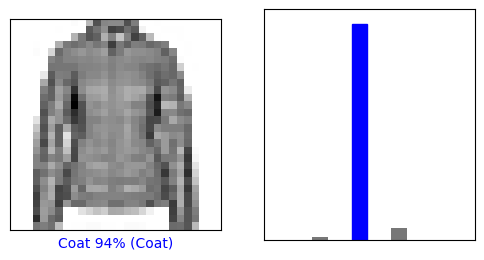

In [41]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

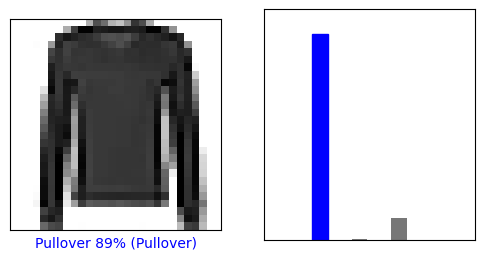

In [42]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

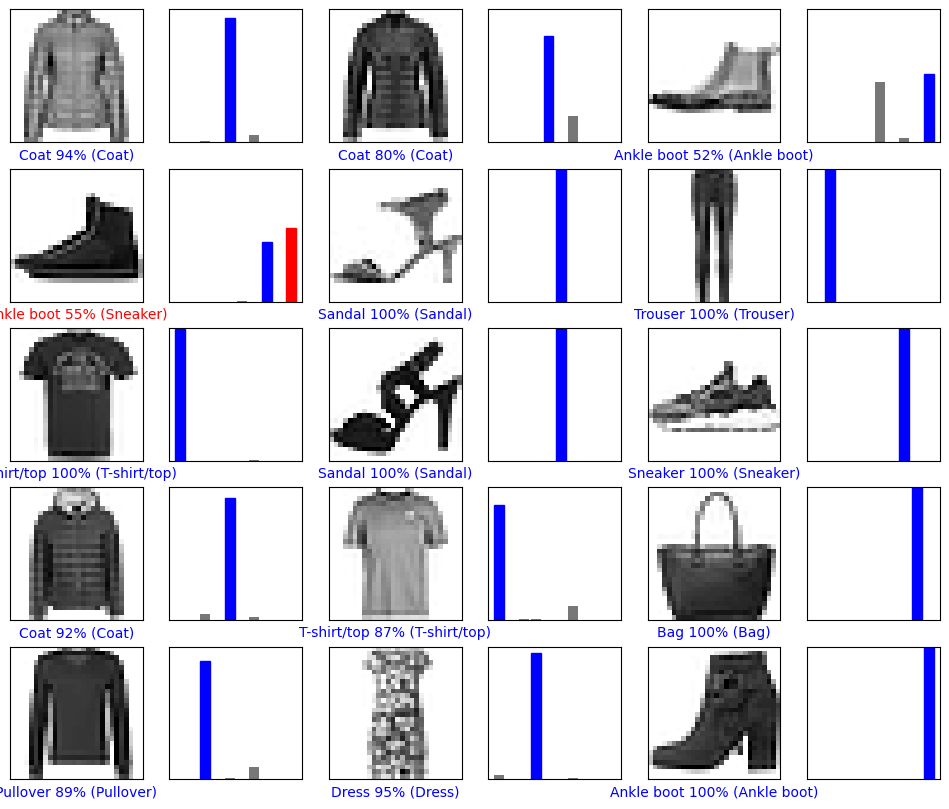

In [43]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [44]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [45]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [46]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 167ms/step
[[2.8335318e-05 9.1232178e-06 1.2393484e-02 4.8262259e-06 9.3658239e-01
  1.3757502e-09 5.0979842e-02 3.4112029e-09 1.9930728e-06 2.9206182e-09]]


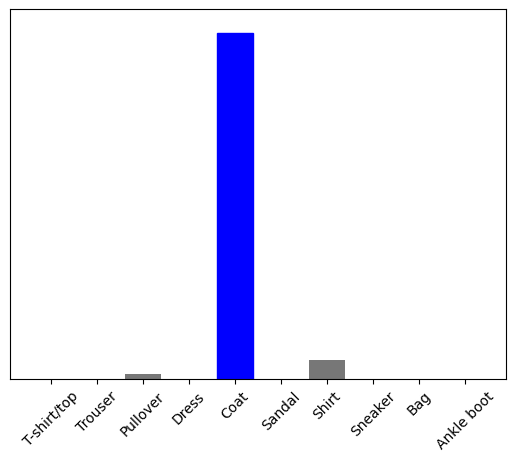

In [47]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [48]:
np.argmax(predictions_single[0])

4